# Домашнее задание к занятию 2.1: Деревья решений. Классификация

## Обзор прошедшего занятия

Что мы делали в классе:

**Задание 1**
* строили деревья
* критерии информативности которых написали даже сами
* визуализировали границы принятия решений в 2d
* и рисовали сами деревья


**Задание 2**
* приняли участие в соревновании на Kaggle, переварив кучу текстовых фичей в численные, проведя кросс-валидацию и сделав сабмит


**Задание 3**
* построили руками несколько метрик качества бинарной классификации


**Задание 4**
* использовали их для оценки классификации разделения статей Ведомостей по топикам

*дополнительно было много приятных ништяков. Например, облако слов, мультипоточность в целях парсинга, удобный инструмент для нахождения правильной css разметки, сохранение моделей в статичные файлы, разделение строк на слова и лемматизация этих слов*

## Домашнее задание

**Lvl 1:**

* взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
* кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )
* определить самые важные фичи
* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

**Результат:** скрины нового сабмита на Kaggle и построенного дерева

**Lvl 2:** (опционально)

* С помощью функций sklearn.metrics.auc, precision, recall составить функцию для расчёта ROC-AUC, ROC-PRC
* Придумать себе интересную задачу на основе данных из интернета =) Спарсить ещё какой-нибудь сайт (не Ведомости) и решить задачу классификации. Делать свои проекты - круто. Если будут - кидайте мне =) [@NikitaKuznetsov](http://t.me/NikitaKuznesov)

In [1]:
%%time
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.externals import joblib

from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import graphviz
import pydotplus
import collections
from sklearn import tree

Wall time: 1.46 s


C:\Program Files\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#Загружаю данные
train = pd.read_csv('data_titanic/train.csv')
test = pd.read_csv('data_titanic/test.csv')

print ("Dimension of train data {}".format(train.shape))
print ("Dimension of test data {}".format(test.shape))

Dimension of train data (891, 12)
Dimension of test data (418, 11)


In [3]:
#train.head()
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# Изучаю данные

#train.isnull().sum()
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [5]:
train.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [6]:
test.Embarked.unique()

array(['Q', 'S', 'C'], dtype=object)

In [7]:
#Разделяю данные и удаляю не нужные столбцы
y = train.Survived
x_train = train.drop(['Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
x_test = test.drop(['Name', 'Ticket', 'Cabin'], axis=1)
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [8]:
#x_train.head()
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           417 non-null float64
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 26.2+ KB


In [9]:
#обрабатываю данные
le = LabelEncoder()
x_train.Sex = le.fit_transform(x_train.Sex)

# Присваиваю в Embarked = NaN значение 'С'. Доказательство тут: https://www.kaggle.com/arthurlu/exploratory-tutorial-titanic/data
x_train.Embarked = x_train.Embarked.fillna('C')
x_train.Embarked = le.fit_transform(x_train.Embarked)

x_test.Sex = le.fit_transform(x_test.Sex)
x_test.Embarked = le.fit_transform(x_test.Embarked)

In [10]:
#x_train.head()
x_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,34.5,0,0,7.8292,1
1,893,3,0,47.0,1,0,7.0000,2
2,894,2,1,62.0,0,0,9.6875,1
3,895,3,1,27.0,0,0,8.6625,2
4,896,3,0,22.0,1,1,12.2875,2


In [11]:
#x_train.Age просто присваиваю медианное значение (ничего лучше не придумал. В работе бы поэкспериментировал: взял бы разные методы или сделал бы его target в можели)

x_train['Age'] = (x_train.Age.fillna(x_train.Age.median()))

x_train.Age = x_train.Age.astype('int')
x_train.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [12]:
#x_test.Age просто присваиваю медианное значение
x_test['Age'] = x_test.Age.fillna(x_test.Age.median())
x_test.Age = x_test.Age.astype('int')
x_test['Fare'] = x_test.Fare.fillna(x_test.Age.median())
x_test.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [13]:
#обучение дерева
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(x_train, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

([<matplotlib.axis.YTick at 0xe2ad4e0>,
 <a list of 8 Text yticklabel objects>)

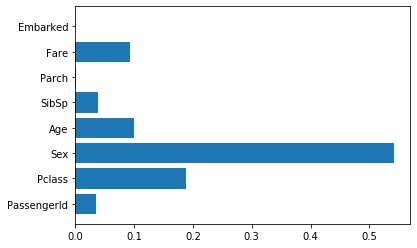

In [14]:
#Оценка важности фич

plt.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_)
plt.yticks(np.arange(len(x_train.columns)),x_train.columns)

In [15]:
X = pd.concat([x_train, x_test], axis=0)
X.index = range(len(X))
X.shape
X.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,1,22,1,0,7.2500,2
1,2,1,0,38,1,0,71.2833,0
2,3,3,0,26,0,0,7.9250,2
3,4,1,0,35,1,0,53.1000,2
4,5,3,1,35,0,0,8.0500,2


In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null int32
Age            1309 non-null int32
SibSp          1309 non-null int64
Parch          1309 non-null int64
Fare           1309 non-null float64
Embarked       1309 non-null int32
dtypes: float64(1), int32(3), int64(4)
memory usage: 66.6 KB


In [17]:
depths = np.arange(1,10)
#features_num = np.arange(5,15)
grid = {'max_depth': depths}#, 'max_features': features_num}
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, scoring='neg_log_loss', cv=5)

In [18]:
%%time
gridsearch.fit(x_train, y)

Wall time: 263 ms


C:\Program Files\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             pre_dispatch='2*n_jobs', refit=True, return_trai

In [19]:
#Визуализируею дерево

from sklearn.tree import export_graphviz

def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))
    


In [21]:
get_tree_dot_view(clf, list(x_train.columns), x_train.columns)

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="Sex <= 0.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]\nclass = PassengerId", fillcolor="#f5cfb4"] ;
1 [label="Pclass <= 2.5\ngini = 0.383\nsamples = 314\nvalue = [81, 233]\nclass = Pclass", fillcolor="#7ebfee"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="Age <= 2.5\ngini = 0.1\nsamples = 170\nvalue = [9, 161]\nclass = Pclass", fillcolor="#44a2e6"] ;
1 -> 2 ;
3 [label="Pclass <= 1.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]\nclass = PassengerId", fillcolor="#ffffff"] ;
2 -> 3 ;
4 [label="gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = PassengerId", fillcolor="#e58139"] ;
3 -> 4 ;
5 [label="gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = Pclass", fillcolor="#399de5"] ;
3 -> 5 ;
6 [label="Fare <= 28.856\ngini = 0.091\nsamples = 168\nvalue = [8, 160]\nclass = Pclass", fillcolor="#43a2e6"] ;
2 -> 6 ;
7 [label="Fare <= 28.231\ngini = 0.182\nsamples = 69\nvalue = [7, 62]\nclass = Pc

In [22]:
#визуализация дерева

#Вывод в файл

dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=x_train.columns,
                                class_names='MERG',
                                filled=True, rounded=True,
                                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
nodes = graph.get_node_list()
edges = graph.get_edge_list()

colors = ('brown', 'forestgreen')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('tree.png')

True

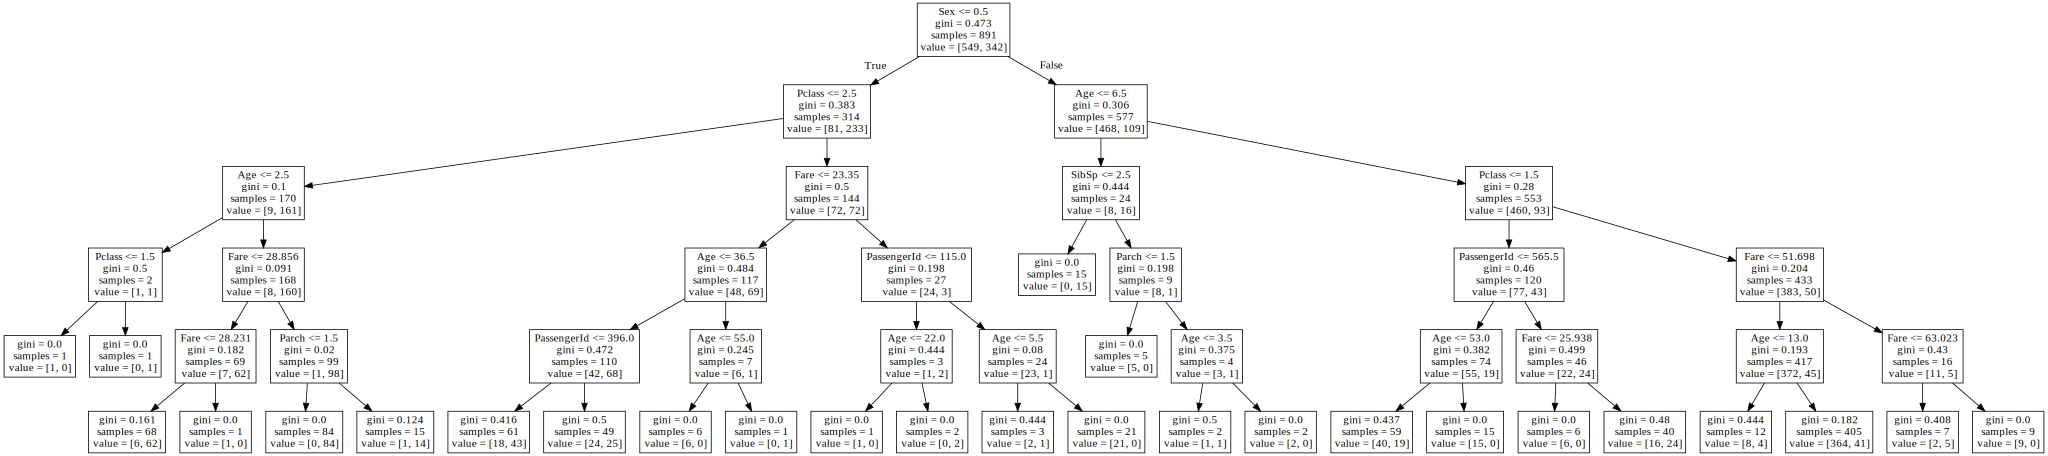

In [23]:
#визуализация дерева

#Вывод в питон

from IPython.display import SVG
from graphviz import Source
from sklearn import tree
graph = Source(tree.export_graphviz(clf, out_file=None, feature_names=x_train.columns))
SVG(graph.pipe(format='svg'))

Source(tree.export_graphviz(clf, out_file=None, feature_names=X.columns))